### **一、预处理**
#### 1. 去噪
&emsp;&emsp;噪声会引入不必要的波动和随机性，在平稳性检验和建立预测模型时造成干扰。因此，如果时序数据中若存在噪声，应当先进行去噪操作，以减少噪声对后续处理的影响。常用的去噪方法有小波变换和傅里叶变换等。
##### (1) 小波变换
&emsp;&emsp;小波变换是一种多尺度分析方法，可以捕捉信号中的瞬时特性和局部结构，**适用于非平稳数据**，可以在不同尺度上进行去噪，以保留信号的重要特征，但是对于某些特定的周期性信号，小波变换可能不如傅里叶变换有效。小波变换进行去噪的示例代码如下：

In [50]:
import pandas as pd
import numpy as np
import pywt

# 导入数据
data = pd.read_csv('../test_data/example_wp_log_peyton_manning.csv')
y = data['y'].to_numpy()

# 选择小波基函数(db适用于各种类型的信号)并指定分解层数
wavelet = 'db4'
level = 4

# 小波分解
coeffs = pywt.wavedec(y, wavelet=wavelet, level=level)
# 设置阈值，这里设置为最后一层的小波系数的标准差的两倍（最后一层通常包含高频噪声）
threshold = np.std(coeffs[-1]) * 2
# 应用阈值进行去噪
coeffs = [pywt.threshold(c, threshold, mode='soft') for c in coeffs]

# 重构去噪后的数据
denoised_y= pywt.waverec(coeffs, wavelet)

# 创建包含timestamp和去噪后的value列的新DataFrame
denoised_data = pd.DataFrame({'ds':data['ds'], 'y': denoised_y})

# 可以选择将去噪后的数据保存到新的CSV文件
denoised_data.to_csv('../test_data/denoised_data_wt.csv', index=False)

##### (2) 傅里叶变换
&emsp;&emsp;傅里叶变换可以将时序数据转换为频域数据，将信号分解成一系列正弦和余弦函数，从而滤除特定频率的噪声。傅里叶变换适用于去除周期性噪声，不适用于处理非平稳数据和非周期性信号中的突发噪声。傅里叶变换进行去噪的示例代码如下：

In [57]:
import numpy as np
import pandas as pd

# 导入数据
data = pd.read_csv('../test_data/example_wp_log_peyton_manning.csv')
y = data['y']

# 进行傅里叶变换
# 这里使用的是numpy里面的fft以避免scipy和mat
freq_y = np.fft.fft(y)

# 将高频噪声部分设置为零（示例中假设5Hz以下的频率成分是信号，5Hz以上的是噪声）
cutoff_frequency = 5  # 时序数据中该参数需要进行试验性调整
freq_y[cutoff_frequency+1:-cutoff_frequency] = 0

# 进行傅里叶逆变换以获得去噪后的信号
denoised_y = np.real(np.fft.ifft(freq_y))

# 创建包含timestamp和去噪后的value列的新DataFrame
denoised_data = pd.DataFrame({'ds':data['ds'], 'y': denoised_y})

# 可以选择将去噪后的数据保存到新的CSV文件
denoised_data.to_csv('../test_data/denoised_data_fft.csv', index=False)

#### 2. 差分
&emsp;&emsp;差分是对时间序列数据进行处理的一种方式，可以用于去除时序数据中的趋势，及那个非平稳的数据转化为平稳的数据。但是差分并不总是使用的，应该根据数据的性质和分析的需求使用不同的差分方式。常见的差分方式有一阶差分、二阶差分、季节性差分、对数差分等，低阶差分可以去除线性趋势，高阶差分可以去除非线性趋势，有利于后续的平稳性检验。差分的示例代码如下：

In [4]:
import pandas as pd
import numpy as np

# 读导入数据
df = pd.read_csv('../test_data/example_wp_log_peyton_manning.csv')

# 一阶差分
df['first_difference'] = df['y'].diff()

# 二阶差分
df['second_difference'] = df['first_difference'].diff()

# 季节性差分（假设季节周期为4，可根据实际情况调整）
seasonal_period = 4
df['seasonal_difference'] = df['y'].diff(seasonal_period)

# 阶数差分（自定义阶数）
order = 3
df[f'{order}-order_difference'] = df['y'].diff(order)

# 对数差分
df['log_difference'] = df['y'].apply(lambda x: x if x == 0 else np.log(x)).diff()

# 保存差分后的数据到新的CSV文件
df.to_csv('../test_data/differenced_data.csv', index=False)

#### 3. 平稳性检验
&emsp;&emsp;平稳性是时序分析的重要概念，包括强平稳与弱平稳，常见的时序分析任务都是基于弱平稳做的。满足**均值为常数**、**方差收敛**以及**协方差仅与时间间隔有关与位置无关**三点的即为若平稳。常用的平稳性检验方法有两种，一种是ACF、PACF图，另一种是假设检验。
##### (1) ACF、PACF图
&emsp;&emsp;ACF是自相关性系数，用于测量时间序列滞后值之间的线性关系；PACF是偏自相关性系数，指剔除了中间k-1个随机变量的影响后，x(t-k)对x(k)影响的相关度量。ACF和PACF图不受样本大小的限制，且不依赖于特定的模型，但是受噪声的影响。绘制ACF和PACF图的示例代码如下（仅为示例）：

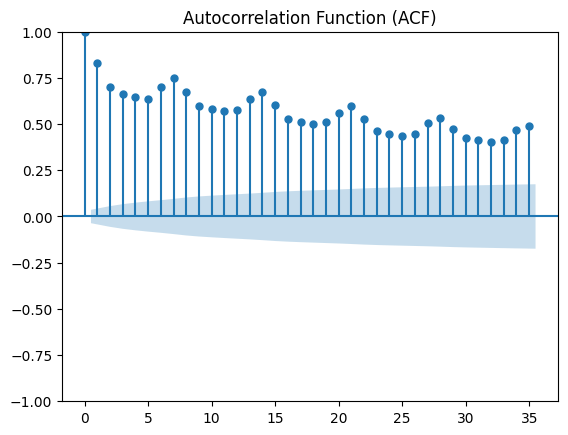

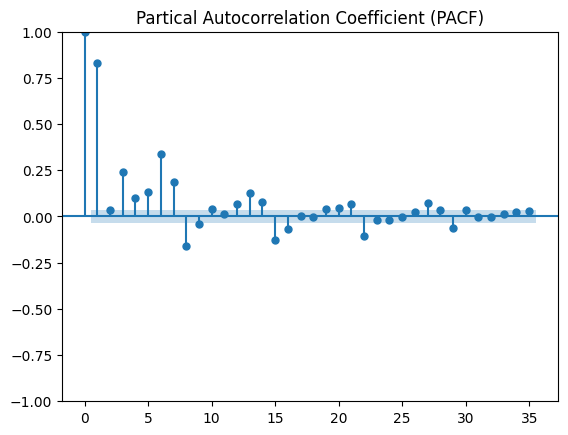

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 读取文件
df = pd.read_csv('../test_data/example_wp_log_peyton_manning.csv')

# 绘制ACF
plot_acf(df['y'])
plt.title('Autocorrelation Function (ACF)')
plt.show()

# 绘制PACF
plot_pacf(df['y'])
plt.title('Partical Autocorrelation Coefficient (PACF)')
plt.show()

&emsp;&emsp;如上图，ACF随着滞后期的增加而缓慢地下降，没有快速的衰减，这表明序列存在长期的相关性；PACF图中的自相关系数随着滞后期的增加而快速地下降到置信区间内，这表明序列具有自回归特性，但不是简单的自回归过程。根据两个图分析可得该数据为非平稳数据。
&emsp;&emsp;其中插入两个概念：拖尾是始终有非零取值，不会在大于某阶后就快速趋近于0；截尾是在大于某阶(k)后快速趋于0为k阶截尾，即从某阶之后直接就变成0，如以上数据，ACF为拖尾，PACF为截尾。因此，**ACF若快速下降到接近0的水平（截尾）则为平稳数据，数据下降缓慢且较大的（拖尾）则为非平稳数据**。以下给出一个平稳性数据的示例（仅为示例）：

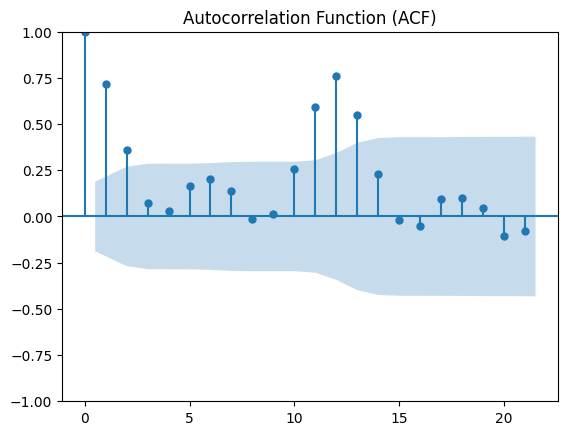

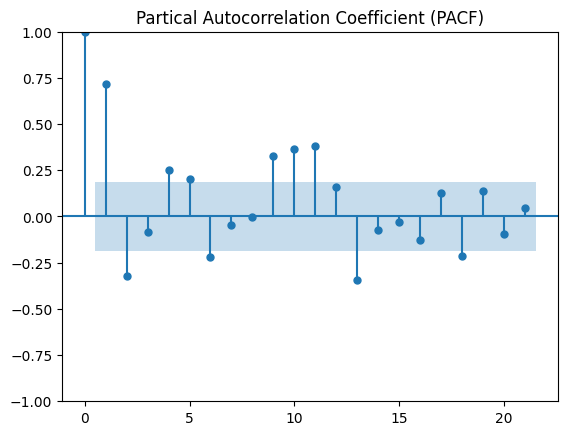

In [12]:
# 加载数据
data = pd.read_csv('../test_data/monthly-car-sales.csv')

# 绘制ACF
plot_acf(data['Sales'])
plt.title('Autocorrelation Function (ACF)')
plt.show()

# 绘制PACF
plot_pacf(data['Sales'])
plt.title('Partical Autocorrelation Coefficient (PACF)')
plt.show()

##### (2) 假设检验
&emsp;&emsp;通过观察ACF和PACF来判断数据的平稳性是一种方法，还可以通过假设检验进一步确认序列的平稳性。常用的用于检测平稳性的假设检验是**ADF检验(Augmented Dickey-Fuller Test)**，p值小于0.05便可以认为平稳。注意，ADF检验需要较大的样本量，且基于一个额定的统计模型，在检验之前需要差分去除数据中的趋势，并去除数据的噪声，否则将导致错误的结论（与ACF图得到的结果相反）。对以上非平稳数据example_wp_log_peyton_manning.csv去噪后，ADF检验的示例代码如下：

In [11]:
from statsmodels.tsa.stattools import adfuller

# 加载数据
df = pd.read_csv('../test_data/denoised_data_wt.csv')
y_list = df['y'].tolist()

# 得到ADF检验结果（传入list类型数据）
result = adfuller(y_list)
print("The result of ADF:")
print(result)

The result of ADF:
(-4.090772573287953, 0.0010031034873099409, 28, 2877, {'1%': -3.43262498927583, '5%': -2.8625451360824843, '10%': -2.5673050630393703}, -1875.814177445879)


关于ADF检验的结果：<br>
第一个值是ADF检验的结果t值，表示t统计量。<br>
第二个值是p值，表示t统计量对应的概率值。<br>
第三个值是延迟。<br>
第四个值是测试的次数。<br>
第五个值是在99%、95%和90%置信区间下的临界值。<br>
① 1%、%5、%10不同程度拒绝原假设的统计值和ADF Test result的比较，ADF Test result同时小于1%、5%、10%即说明非常好地拒绝该假设。在该数据中-4.0远小于三个临界值。<br>
② p值要求小于给定的显著水平，p值要小于0.05，等于0是最好的。在该数据中0.0002远小于0.05.<br>
**只要ADF检验的统计值t小于1%水平以下、p值小于0.05就可以认为数据平稳**。因此根据ADF检验的结果，以上数据为平稳数据。

#### 4. 平稳性转换
&emsp;&emsp;平稳性转换用于将非平稳性时间序列数据转化为平稳性数据，以便进行更有效的时间序列分析和预测。常用的平稳性转换方法有变形、减去移动平均、指数平均、差分（对于大部分时序数据来说，二阶差分后都可以得到平稳序列）等，其中差分在以上进行了介绍，其他几种方法的示例代码如下：

In [6]:
import pandas as pd
import numpy as np

# 导入数据
df = pd.read_csv('../test_data/example_wp_log_peyton_manning.csv')
y = data['y']  # 选择CSV文件中的时间序列列

# 变换 (这里示例使用对数变换)
df['log_transformed'] = np.log(y)

# 减去移动平均 (示例中使用窗口大小为3的移动平均)
moving_avg = y.rolling(window=3).mean()
df['detrended'] = y - moving_avg

# 指数平均 (示例中使用指数平均窗口大小为3)
df['exponential_avg'] = y.ewm(span=3).mean()

# 保存平稳性转换后的数据到心的csv文件
df.to_csv('../test_data/transformed_data.csv', index=False)

##### 5. 以上预处理的步骤可以**根据实际情况选择**其中的预处理和方法，对于含有噪音的非平稳数据的完整预处理代码如下（只是处理示例）：

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pywt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 导入数据
data = pd.read_csv('../test_data/example_wp_log_peyton_manning.csv')
y = data['y'].to_numpy()

# 小波变换去噪
wavelet = 'db4'
level = 4
coeffs = pywt.wavedec(y, wavelet=wavelet, level=level)
threshold = np.std(coeffs[-1]) * 2
coeffs = [pywt.threshold(c, threshold, mode='soft') for c in coeffs]
denoised_y= pywt.waverec(coeffs, wavelet)
denoised_data = pd.DataFrame({'ds':data['ds'], 'y': denoised_y})

# 绘制ACF PACF判断平稳性
plot_acf(denoised_data['y'])
plt.title('Autocorrelation Function (ACF)')
plt.show()
plot_pacf(denoised_data['y'])
plt.title('Partical Autocorrelation Coefficient (PACF)')
plt.show()

# 二阶差分平稳化
first_diff = data['y'].diff()
second_diff = first_diff.diff()

# 创建包含timestamp和去噪后的value列的新DataFrame
clean_data = pd.DataFrame({'ds':data['ds'], 'y': second_diff})

# 可以选择将去噪后的数据保存到新的CSV文件
# clean_data.to_csv('../test_data/clean_data.csv', index=False)

### **二、Prophet**（由于编译器的问题无法正常下载该包，舍弃）
#### 1. 算法简介
&emsp;&emsp;Prophet是Facebook开源的时间序列预测算法，可以有效处理节假日信息，并按周、月、年对时间序列数据的变化趋势进行拟合。Prophet对具有强烈周期性特征的历史数据拟合效果很好，不仅可以处理时间序列存在一些异常值的情况，也可以处理部分缺失值的情形。
#### 2. 使用场景
Prophet适用于具有<font color=red>明显周期性规律</font>的数据，只能够进行<font color=red>单指标</font>时序预测。例如有以下特征的业务问题：<br>
(1) 有至少几个月（最好是一年）的每个小时/每天/每周的历史数据；<br>
(2) 有多种人类规模级别的较强的季节性趋势；<br>
(3) 有事先知道的以不定期的间隔发生的重要节假日；<br>
(4) 缺失的历史数据或较大的异常数据的数量在合理范围内。<br>
#### 3. 算法原理
![Excalidraw Image](../pictures/Prophet.png)<br>
&emsp;&emsp;整个算法模型由增长趋势growth、季节趋势seasonality和节假日对预测值的影响holidays三部分组成。其中g(t)表示趋势项，表示时间序列在非周期上面的变化趋势；s(t)表示周期项/季节项；h(t)表示节假日项，表示时间序列中那些潜在的具有非固定周期的节假日对预测值造成的影响；最后一项是误差项/剩余项，表示模型为预测到的波动，服从高斯分布。算法通过拟合这几项，然后将它们累加起来得到了时间序列的预测值。<br>
**论文原文链接**：<https://peerj.com/preprints/3190.pdf>

### **二、Holt-Winter**
#### 1. 算法简介
&emsp;&emsp;Holt-Winter方法其实是三次指数平滑。离预测点越近的点作用越大，因此将权重按照指数级进行衰减，这就是指数平滑的基本思想。所有指数平滑法都要更新上一时间步长的计算结果，并使用当前的时间步长的数据中包含的新信息，通过“混合”新旧信息来实现，并控制新旧信息的权重。
#### 2. 使用场景
对于三种指数平滑方法：<br>
(1) 一次指数平滑(Exponential smoothing)针对<font color='red'>没有趋势和季节性</font>的序列；<br>
(2) 二次指数平滑(Holt exponential smoothing)针对<font color='red'>有趋势但没有季节性</font>的序列；<br>
(3) 三次指数平滑(Holt-Winters exponential smoothing)针对<font color='red'>有趋势且有季节性</font>的序列。<br>
使用Holt-Winter之前先要对数据进行<font color='red'>预处理</font>。
#### 3. 算法原理
![Excalidraw Image](../pictures/Holt.png)<br>
&emsp;&emsp;一次指数平滑的递推关系中可见时间步长为i(第i个时间点)上经过平滑的值是当前时间的实际数据xi和之前平滑的值si-1的加权和，α控制着新旧信息的平衡（权重）。所有先前的观测值都对当前的平滑值产生了影响，但它们所起的作用随着参数α的幂的增大而逐渐减小，一次指数平滑的预测值为si。<br>
&emsp;&emsp;二次指数平滑在此基础上将趋势作为一个额外的考量，需要更新平滑后的信号以及平滑后的趋势两个量的状态（使用一次指数平滑对趋势进行处理，β控制平衡），预测的值同时考虑平滑信号和趋势取最后那个平滑值，然后每增加一个时间步长就在该平滑值上增加一次最后的平滑趋势。<br>
&emsp;&emsp;三次指数平滑增加了周期性pi，在前两个基础上增加了季节分量，同时也对季节分量做指数平滑，预测值同时考虑了三者。<br>
#### 4. 运行示例(仅示例Holt-Winter)
(1) 导入Holt-Winter相关包

In [28]:
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

(2) 导入数据并对原始数据进行可视化（方便观察趋势进行了放大）

<Axes: title={'center': 'Time Series Original Data'}, xlabel='ds'>

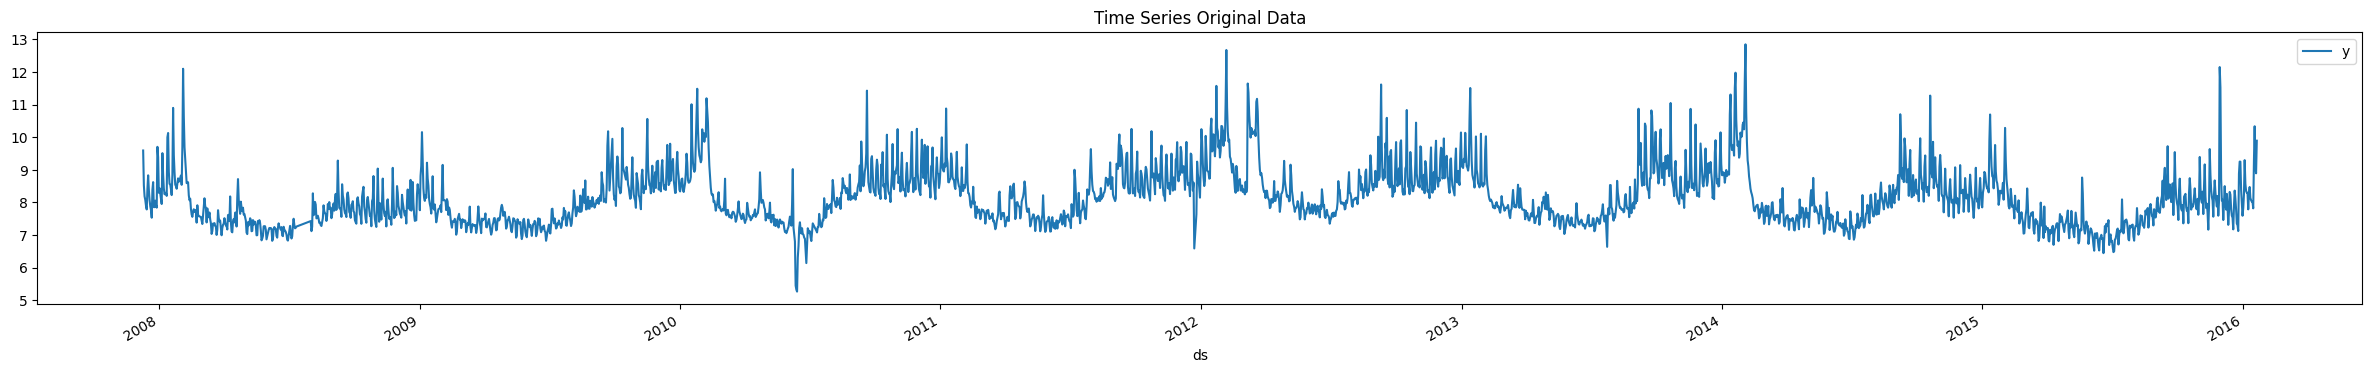

In [29]:
# 导入数据
data = pd.read_csv('../test_data/example_wp_log_peyton_manning.csv', index_col='ds', parse_dates=True)
# 原始数据可视化
data[['y']].plot(title='Time Series Original Data', figsize=(30,4))

(3) 查看模型训练效果（实际可以不用）：进行三次指数平滑，并对训练的结果进行可视化，这里分别使用了加法模型和乘法模型进行演示。加法模型适用于**季节性变化幅度相对稳定**的情况，乘法模型适用于季节性变化的**幅度随着趋势的变化而变化**的情况。从可视化的图中（可放大）可见两个模型的拟合效果均不错

d:\LogReduce\aiops-notebook\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\LogReduce\aiops-notebook\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\LogReduce\aiops-notebook\.venv\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


<Axes: title={'center': 'Holt Winters Triple Exponential Smoothing: Additive and Multiplicative Seasonality'}, xlabel='ds'>

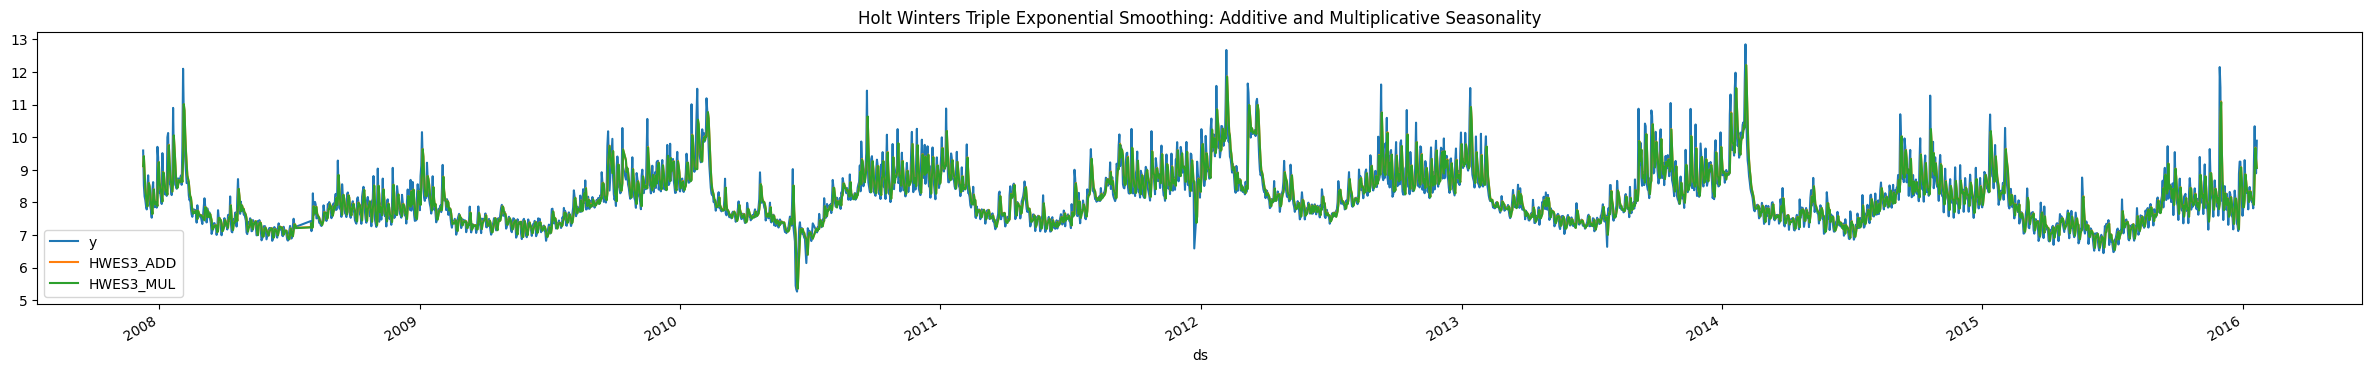

In [31]:
# 使用加法模型
data['HWES3_ADD'] = ExponentialSmoothing(data['y'], trend='add', seasonal='add', seasonal_periods=12).fit().fittedvalues
# 使用乘法模型
data['HWES3_MUL'] = ExponentialSmoothing(data['y'], trend='mul', seasonal='mul', seasonal_periods=12).fit().fittedvalues
# 可视化训练结果
data[['y','HWES3_ADD','HWES3_MUL']].plot(title='Holt Winters Triple Exponential Smoothing: Additive and Multiplicative Seasonality', figsize=(30,4))

(4) 对数据集机型划分，对模型进行训练（这里只演示乘法模型，加法模型trend和seasonal设置为add即可），并对未来数据进行预测

d:\LogReduce\aiops-notebook\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
d:\LogReduce\aiops-notebook\.venv\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Text(0.5, 1.0, 'Train, Test and Predicted Test using Holt Winters')

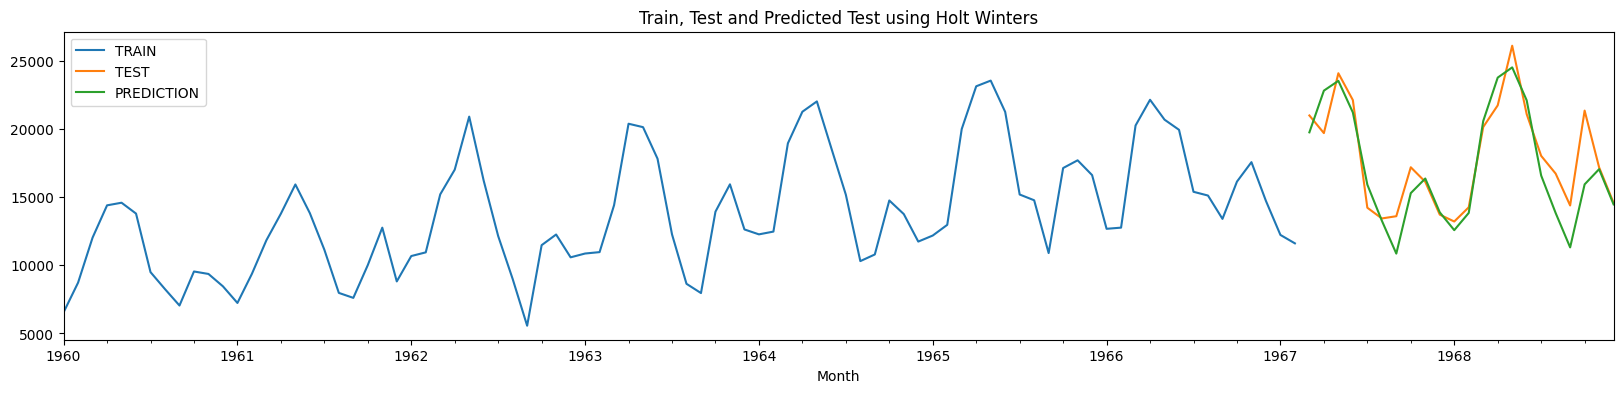

In [67]:
from sklearn.model_selection import train_test_split

# 划分训练集和测试集，为了不打乱时间顺序，通过切片进行划分
forecast_data = pd.read_csv('../test_data/monthly-car-sales.csv', index_col='Month', parse_dates=True)
split_index = int(0.8 * len(forecast_data))
train = forecast_data.iloc[:split_index]
test = forecast_data.iloc[split_index:]

# 模型训练（乘法模型）与预测
model = ExponentialSmoothing(train['Sales'], trend='mul', seasonal='mul', seasonal_periods=12).fit()
prediction_results = model.forecast(len(test)) # 对未来test长度天的值进行预测

# 可视化结果
train['Sales'].plot(legend=True, label='TRAIN')
test['Sales'].plot(legend=True, label='TEST', figsize=(20,4))
prediction_results.plot(legend=True, label='PREDICTION')
plt.title('Train, Test and Predicted Test using Holt Winters')

### **三、SARIMA**
#### 1. 算法简介
&emsp;&emsp;SARIMA（季节性自回归整合滑动平均）是一种用于时序预测的统计模型，它扩展了ARIMA（自回归整合滑动平均）模型。一般时序数据很难满足平稳性要求，比较常用的转化方法就是差分，所以<font color=red>ARIMA(p,q,d)</font>在<font color=red>ARMA(p,q)</font>的基础上将差分的过程包含了进来，因此ARIMA可以处理非平稳时间序列，但是不能很好处理周期性序列。因此<font color=red>SARIMA(p,q,d,P,Q,D,s)</font>又在<font color=red>ARIMA(p,q,d)</font>的基础上进行拓展增加了P Q D三个超参以及一个季节性周期参数s，可以支持带有季节性成分的时序数据。
#### 2. 使用场景
&emsp;&emsp;SARIMA适用于具有<font color=red>季节性变化</font>的时间序列数据，且<font color=red>数据量要较大</font>，数据量太少模型的效果较差。
#### 3. 算法原理
SARIMA包括季节性相关项(S)、自回归(AR)、差分(I)和平均移动(MA)四个部分：<br>
(1) **AR（自回归）部分**表示当前值与过去值之间的依赖关系，即当前值与过去若干个时间点的值之间存在线性关系，可以通过PACF确定合适的滞后阶数，对应参数p；<br>
(2) **I（差分）部分**是为了消除数据的非平稳性，通过对时序数据进行差分处理，可以将非平稳时序数据转化为平稳的时序数据，对应参数d；<br>
(3) **MA（移动平均）部分**表示当前值与过去若干个时间点的观测误差之间的依赖关系，可以通过ACF确定合适的滞后阶数，对应参数q；<br>
(4) **S（季节性项）部分**包括季节性回归(SAR)、季节性差分(SI)、季节性移动平均(SMA)和季节性频率(s)四部分，分别对应参数P、D、Q、s。前三个季节性项与ARIMA模型中的对应项具有相似的作用。<br>
&emsp;&emsp;总结起来，SARIMA模型利用自回归、差分和移动平均等技术，以及考虑季节性的相关项，对具有季节性和趋势性的时间序列数据进行预测。
#### 4. 运行示例
(1) 导入相关的包和数据，注意导入数据时要指定index为数据中的时间，否则数据集划分时将会出现问题

In [22]:
import pandas as pd
import numpy as np
import pmdarima as pm
from pmdarima.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# 加载 CSV 文件
data = pd.read_csv('../test_data/monthly-car-sales.csv', parse_dates=['Month'], index_col='Month')

(2) 划分训练集和数据集，并通过训练集以及auto-arima来拟合模型获取SARIMA模型所需要的最佳超参

In [23]:
# 划分训练集和测试集
train, test = train_test_split(data, train_size=0.8)

# 使用Auto-Arima拟合模型
model = pm.auto_arima(train,
              start_p=0,   # p最小值
              start_q=0,   # q最小值
              test='adf',  # ADF检验确认差分阶数d
              max_p=5,     # p最大值
              max_q=5,     # q最大值
              m=12,        # 季节性周期长度，当m=1时则不考虑季节性
              d=None,      # 通过函数来计算d
              seasonal=True, start_P=0, D=1, trace=True,
              error_action='ignore', suppress_warnings=True,
              stepwise=False  # stepwise为False则不进行完全组合遍历
              )

 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1322.166, Time=0.07 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1306.648, Time=0.20 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1306.323, Time=0.46 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1305.500, Time=0.06 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1306.899, Time=0.09 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=1308.222, Time=0.51 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1306.518, Time=0.15 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=0.58 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=1300.101, Time=1.20 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1301.045, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1290.620, Time=0.29 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1288.515, Time=0.69 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1287.645, Time=0.27 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1289.585, Time=0.42 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1289.843, Time=0.89 sec


(3) 获取SARIMA模型的参数：(p, q, d)，(P, Q, D, s)

In [24]:
order = model.get_params()['order']
seasonal_order = model.get_params()['seasonal_order']
print(order)
print(seasonal_order)

(0, 1, 3)
(1, 1, 0, 12)


(4) 拟合SARIMA模型

In [25]:
sarima_model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
sarima_result = sarima_model.fit()

d:\LogReduce\aiops-notebook\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
d:\LogReduce\aiops-notebook\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


(5) 进行时序预测并可视化预测的结果，其中蓝色为训练数据，绿色为测试数据，红色为模型预测的数据

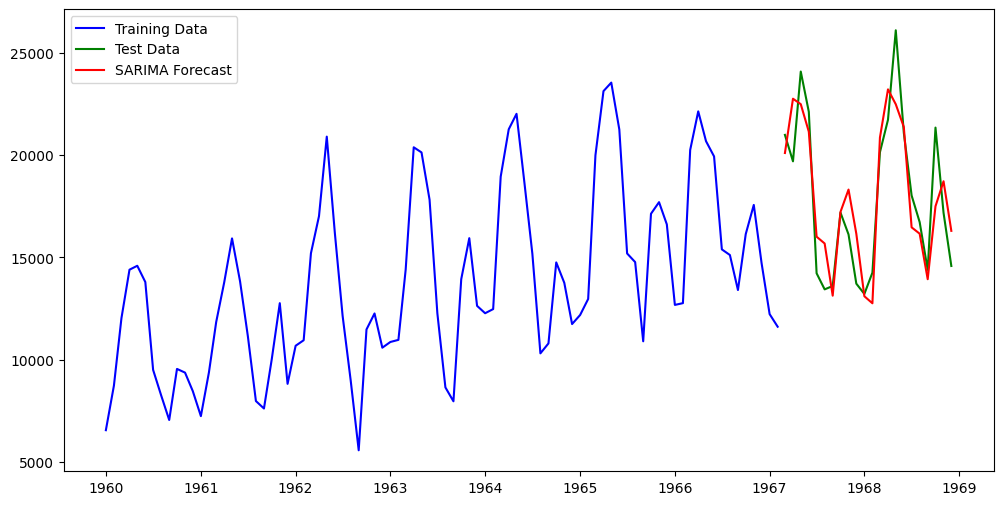

In [26]:
# 利用训练好的SARIMA模型进行时序预测
forecast = sarima_result.get_forecast(steps=len(test))
forecast_mean = forecast.predicted_mean

# 可视化预测结果
plt.figure(figsize=(12, 6))
plt.plot(train, label='Training Data', color='blue')
plt.plot(test, label='Test Data', color='green')
plt.plot(forecast_mean, label='SARIMA Forecast', color='red')
plt.legend()
plt.show()

### **四、LSTM**
#### 1. 算法简介
&emsp;&emsp;长短记忆(Long Short Term Memory, LSTM)是一种特殊的递归神经网络，可以利用时间序列对输入进行分析，从而运用到时间维度的信息。LSTM被设计用于解决一般递归神经网络中普遍存在的长期以来问题，使用LSTM可以有效的传递和表达长时间序列中的信息并且不会导致长时间前的有用信息被忽略（遗忘），与此同时还可以解决简单RNN容易出现梯度消失和梯度爆炸的问题。
#### 2. 使用场景
&emsp;&emsp;LSTM适用于处理<font color='red'>多变量</font>的时序数据，本文中给的示例就是根据多变量数据预测单变量。
#### 3. 算法原理
![Excalidraw Image](../pictures/LSTM.png)<br>
&emsp;&emsp;LSTM主要包括三个门，遗忘门表示上个时间点的状态我应该遗忘多少；输入门控制加入多少主线的“剧情”和拿多少上一个的输出；输出们则是决定需要被输出的部分，详细而言，LSTM内部的三个阶段为：<br>
(1) **忘记阶段**：这个阶段主要是对上个节点传进来的输入进行选择性忘记，通过计算得到忘记门控，从而控制上一个状态c(t-1)哪些需要留下哪些需要忘记；<br>
(2) **选择记忆阶段**：这个阶段将这个阶段的输入有选择性地进行记忆。主要是对输入x(t)进行选择性记忆，哪些重要则多记忆一些。当前的输入内容由前面计算得到的表示，由门控信号控制将两步得到的结果相加，即得到传输给下一个转台的值；<br>
(3) **输出阶段**：这个阶段将决定哪些将会被当成当前状态的输出，并且对上一阶段得到的值进行了缩放。
#### 4. 运行示例
(1) 导入相关的包（这里使用的是python3.7的版本）

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import LSTM
from tensorflow.python.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

(2) 定义时序预测相关函数，具体功能见注释

In [2]:
# 拆分函数：将数据的label和features拆分开（注意是由前n_past个变量预测得到下一个变量的值）
def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
        dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]]) # 三维
        dataY.append(dataset[i,0]) # 一维
    return np.array(dataX),np.array(dataY)

# 模型构造函数：构造LSTM预测模型
def build_model(optimizer):
    grid_model = Sequential()
    grid_model.add(LSTM(50,return_sequences=True,input_shape=(30,5)))
    grid_model.add(LSTM(50))
    grid_model.add(Dropout(0.2))
    grid_model.add(Dense(1))
    grid_model.compile(loss = 'mse',optimizer = optimizer)
    return grid_model

(3) 导入数据，并将其按照时间顺序分割成训练集和数据集

In [3]:
forecast_data = pd.read_csv('../test_data/train.csv', index_col='Date', parse_dates=True)
split_index = int(0.8 * len(forecast_data))
train = forecast_data.iloc[:split_index]
test = forecast_data.iloc[split_index:]

(4) 将数据进行归一化，使其范围在0-1之间

In [4]:
scaler = MinMaxScaler(feature_range=(0,1))
train_scaled = scaler.fit_transform(train)
test_scaled=scaler.transform(test)

(5) 使用createXY对数据进行分割（因为是多变量的时序预测因此不能直接进行分割）

In [5]:
trainX, trainY=createXY(train_scaled,30)
testX, testY=createXY(test_scaled,30)

(6) 构建并训练LSTM时序预测模型，保存模型的最佳参数（寻参需要一定的时间）

In [6]:
# 构建模型
grid_model = KerasRegressor(build_fn=build_model, verbose=1, validation_data=(testX, testY))
parameters = {
    'batch_size': [16, 20],
    'epochs': [8, 10],
    'optimizer': ['adam', 'Adadelta']
}
grid_search = GridSearchCV(estimator=grid_model, param_grid=parameters, cv=2)

# 训练模型
grid_search = grid_search.fit(trainX,trainY)

# 为避免每次重新寻参数，可以保存模型最佳参数或者直接保存模型
print(grid_search.best_params_)
my_model=grid_search.best_estimator_.model

d:\softwares\pycharm\Anaconda\envs\aiops\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  


Epoch 1/8
130/130 [==============================] - 19s 79ms/step - loss: 0.0049 - val_loss: 0.0031
Epoch 2/8
130/130 [==============================] - 9s 71ms/step - loss: 9.6443e-04 - val_loss: 0.0032
Epoch 3/8
130/130 [==============================] - 11s 82ms/step - loss: 9.8222e-04 - val_loss: 0.0023
Epoch 4/8
130/130 [==============================] - 9s 71ms/step - loss: 8.5967e-04 - val_loss: 0.0018
Epoch 5/8
130/130 [==============================] - 9s 67ms/step - loss: 8.2293e-04 - val_loss: 0.0026
Epoch 6/8
130/130 [==============================] - 10s 78ms/step - loss: 7.6439e-04 - val_loss: 0.0016
Epoch 7/8
130/130 [==============================] - 9s 72ms/step - loss: 7.3591e-04 - val_loss: 0.0018
Epoch 8/8
130/130 [==============================] - 2s 17ms/step - loss: 0.0144
Epoch 1/8
130/130 [==============================] - 18s 74ms/step - loss: 0.0168 - val_loss: 0.0038
Epoch 2/8
130/130 [==============================] - 8s 61ms/step - loss: 0.0031 - val_loss

(7) 使用训练好的模型进行预测（用train中有标签的test数据），并对结果进行可视化

Pred Values--  [189.65984  191.0579   192.21663  ... 102.895836 104.02433  105.250885]

Original Values--  [191.692307 193.461533 192.307693 ... 104.550003 105.290001 106.      ]


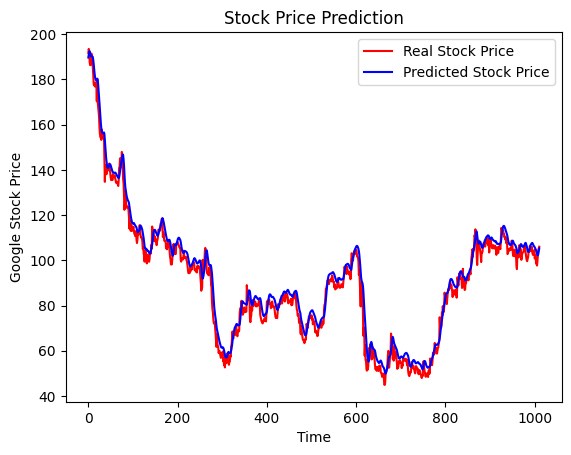

In [7]:
# 预测
prediction=my_model.predict(testX)
# 逆缩放（在缩放数据时，我们每行有5列，现在我们只有目标列1列，所以必须改变形状来使用inverse_transform）
prediction_copies_array = np.repeat(prediction,5, axis=-1)
# 5 列值是相似的，它只是将单个预测列复制了4次。所以现在我们有5列相同的值，现在可以使用inverse_transform
pred=scaler.inverse_transform(np.reshape(prediction_copies_array,(len(prediction),5)))[:,0]
# 与testY进行比较，同样也要逆缩放
original_copies_array = np.repeat(testY,5, axis=-1)
original=scaler.inverse_transform(np.reshape(original_copies_array,(len(testY),5)))[:,0]
print("Pred Values-- " ,pred)
print("\nOriginal Values-- " ,original)

# 可视化
plt.plot(original, color = 'red', label = 'Real Stock Price')
plt.plot(pred, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

(8) 使用训练好的模型对未来的值进行预测，首先对数据进行处理

In [9]:
# 首先保留过去30天的值（通过前n_past个的值预测n_past+1的值）
df_30_days_past=forecast_data.iloc[-30:,:]

# 导入没有标签的test数据对Open进行预测
df_30_days_future=pd.read_csv("../test_data/test.csv",parse_dates=["Date"],index_col=[0])

# test数据中没有Open列，因此要添加所有值都为0的open列
df_30_days_future["Open"]=0
df_30_days_future=df_30_days_future[["Open","High","Low","Close","Adj Close"]]
# 对数据进行缩放
old_scaled_array=scaler.transform(df_30_days_past)
new_scaled_array=scaler.transform(df_30_days_future)
new_scaled_df=pd.DataFrame(new_scaled_array)
# 缩放后Open所有值替换为nan
new_scaled_df.iloc[:,0]=np.nan
# 附加 30 天旧值和 30 天新值
full_df=pd.concat([pd.DataFrame(old_scaled_array),new_scaled_df]).reset_index().drop(["index"],axis=1)

(9) 要进行预测必须再次使用 for 循环，我们在拆分 trainX 和 trainY 中的数据时用createXY同样进行了拆分，但是这次我们只有 X，没有 Y 值

In [10]:
full_df_scaled_array = full_df.values
all_data = []
time_step = 30

for i in range(time_step, len(full_df_scaled_array)):
    data_x = []
    data_x.append(full_df_scaled_array[i - time_step:i, 0:full_df_scaled_array.shape[1]])
    data_x = np.array(data_x)
    prediction = my_model.predict(data_x)
    all_data.append(prediction)
    full_df.iloc[i, 0] = prediction

(10) 最后对预测进行逆变换

In [11]:
new_array=np.array(all_data)
new_array=new_array.reshape(-1,1)
prediction_copies_array = np.repeat(new_array,5, axis=-1)
y_pred_future_30_days = scaler.inverse_transform(np.reshape(prediction_copies_array,(len(new_array),5)))[:,0]
print(y_pred_future_30_days)

[106.41212  107.01789  107.52641  107.881584 108.04415  107.92678
 107.93967  107.93452  107.827835 107.43675  106.89936  106.45679
 106.37269  106.385544 106.5243   106.8562   106.97271  106.97815
 107.11568  107.72207  108.0058   108.10487  108.08673  108.21894
 108.44712  108.57416  108.5553   108.977646 109.57783  110.71307 ]
